LeNet模型建立

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


模型训练

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()   # 设置为评估模式
        if not device: # 没设置设备
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2) # 累加
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]  # 精度，即正确预测的数量/总预测的数量

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """
    用GPU训练模型, 内部使用随机梯度下降、交叉熵损失(适用于分类任务)
    训练内容可视化
    """
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:  # 对线性层和卷积层的参数初始化，xavier均匀分布
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)  # 初始化
    print('training on', device)
    net.to(device)   # 设置使用GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # 优化器，随机梯度下降
    loss = nn.CrossEntropyLoss()                          # 损失函数，交叉熵损失

    # 训练内容可视化
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train_loss', 'train_acc', 'test_acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):  
        # 训练损失，训练准确样本数，样本总数
        metric = d2l.Accumulator(3)  # 累加
        net.train()      # 设置为训练模式
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) # GPU
            y_hat = net(X)
            l = loss(y_hat, y)                # 执行前向传播，计算损失
            l.backward()                      # 执行反向传播，计算梯度    
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y),  X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]   # 训练损失/样本总数
            train_acc = metric[1]/metric[2] # 训练准确样本数/样本总数
            # 每个小批量，分为5次输出数据
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches-1:  # // 向下取整的除法
                animator.add(epoch+(i+1)/num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)  # 一轮训练完后，测试集计算损失
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(device)}') # 每秒跑多少样本


loss 0.471, train acc 0.822, test acc 0.798
9050.2 examples/sec on cpu


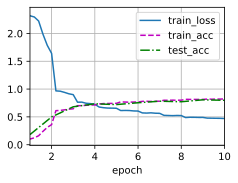

In [7]:
lr, num_epochs = 0.9, 10

# 这里实际是用cpu
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.474, train acc 0.821, test acc 0.803
19085.1 examples/sec on xpu:0


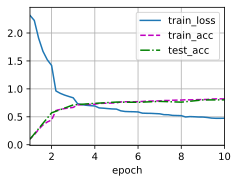

In [8]:
# 本电脑Intel集成GPU, 需自己实现xpu
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())

练习

将平均汇聚层替换为最大汇聚层

loss 0.423, train acc 0.841, test acc 0.783
22147.9 examples/sec on xpu:0


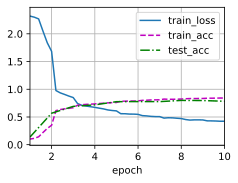

In [9]:
my_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

train_ch6(my_net, train_iter, test_iter, num_epochs, lr, try_xpu())

显示不同输入(例如，毛衣和外套)时LeNet第一层和第二层的激活值

In [17]:
def my_train_ch6(net, train_iter,lr, device):
    """
    用GPU训练模型, 内部使用随机梯度下降、交叉熵损失(适用于分类任务)
    显示不同输入, LeNet第一层和第二层的激活值
    """
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:  # 对线性层和卷积层的参数初始化，xavier均匀分布
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)  # 初始化
    print('training on', device)
    net.to(device)   # 设置使用GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  # 优化器，随机梯度下降
    loss = nn.CrossEntropyLoss()                          # 损失函数，交叉熵损失

    for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) # GPU
            x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
            d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
            x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
            d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)
            y_hat = net(X)
            l = loss(y_hat, y)                # 执行前向传播，计算损失
            l.backward()                      # 执行反向传播，计算梯度    
            optimizer.step()
            break

training on xpu:0


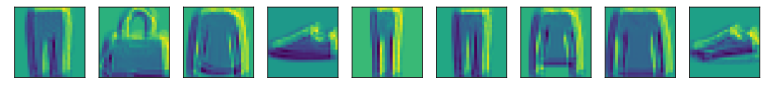

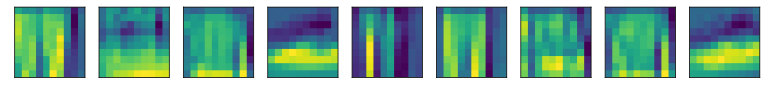

In [18]:
my_train_ch6(net, train_iter, lr, try_xpu())